# 📌 **Introduction**  

Hầu hết các kỹ thuật trong khóa học này đều áp dụng cho **đặc trưng số**.  

✅ Kỹ thuật trong bài này - **target encoding** - dành riêng cho **đặc trưng phân loại**.  

📊 Đây là một phương pháp **mã hóa danh mục thành số**, giống như **one-hot encoding** hoặc **label encoding**,  
nhưng có một điểm khác biệt: nó sử dụng **giá trị mục tiêu** để tạo mã hóa.  

🚀 Vì vậy, **target encoding** là một kỹ thuật **feature engineering có giám sát** (*supervised*).

In [33]:
import pandas as pd

autos = pd.read_csv("autos.csv")

# 🎯 **Target Encoding**  

📌 **Target encoding** là phương pháp **mã hóa danh mục** bằng cách thay thế mỗi **giá trị phân loại**  
bằng một **số liệu thống kê** được tính toán từ **biến mục tiêu**.  

✅ Một cách đơn giản và hiệu quả là **tính trung bình theo nhóm** (*group aggregation*), như trong **Bài 3**.  

📊 Ví dụ với tập dữ liệu *Automobiles*, chúng ta có thể **tính giá trung bình** của mỗi **hãng xe**:  

In [34]:
autos["make_encoded"] = autos.groupby("make")["price"].transform("mean")

autos[["make", "price", "make_encoded"]].head(10)

,make,price,make_encoded
0,alfa-romero,13495,15498.333333
1,alfa-romero,16500,15498.333333
2,alfa-romero,16500,15498.333333
3,audi,13950,17859.166667
4,audi,17450,17859.166667
5,audi,15250,17859.166667
6,audi,17710,17859.166667
7,audi,18920,17859.166667
8,audi,23875,17859.166667
9,bmw,16430,26118.750000


## 🎯 **Target Encoding**  

📌 **Mean Encoding** là một dạng **target encoding** phổ biến. Khi áp dụng cho biến mục tiêu nhị phân, nó còn được gọi là **bin counting**.  
📌 Một số tên khác mà bạn có thể gặp: **likelihood encoding**, **impact encoding**, **leave-one-out encoding**.

---

## 🔄 **Smoothing trong Target Encoding**

Target encoding có thể gặp hai vấn đề chính:

1️⃣ **Danh mục không xác định** (*Unknown categories*):
   - Khi áp dụng target encoding, có nguy cơ **quá khớp** (*overfitting*).
   - Cần chia tập dữ liệu thành phần "encoding" riêng biệt để huấn luyện.
   - Khi áp dụng cho các tập dữ liệu khác, Pandas sẽ điền giá trị thiếu cho các danh mục chưa từng xuất hiện.

2️⃣ **Danh mục hiếm gặp** (*Rare categories*):
   - Nếu một danh mục chỉ xuất hiện rất ít lần, thống kê của nó có thể **không chính xác**.
   - Ví dụ: Trong tập *Automobiles*, hãng `mercury` chỉ xuất hiện **một lần** → Giá trung bình của `mercury` chỉ dựa trên một mẫu, không phản ánh tổng thể.
   - Điều này có thể làm tăng khả năng **overfitting**.

✅ **Giải pháp**: **Thêm smoothing** ✨

📌 **Ý tưởng:** Kết hợp **giá trị trung bình trong nhóm** với **trung bình toàn bộ dữ liệu**. 
- 🟢 **Danh mục hiếm** → Ít ảnh hưởng từ giá trị trung bình trong nhóm.
- 🟡 **Danh mục không có dữ liệu** → Lấy trung bình toàn bộ.

📌 **Công thức (pseudocode):**
```python
encoding = weight * in_category + (1 - weight) * overall
```
📌 **Tính trọng số `weight` theo công thức `m-estimate`:**
```python
weight = n / (n + m)
```
Trong đó:
- `n` là số lần danh mục xuất hiện.
- `m` là tham số xác định mức độ **smoothing** (giá trị lớn giúp giảm overfitting).

📌 **Ví dụ với tập *Automobiles***: 

Giả sử có **ba xe Chevrolet**, chọn `m=2.0`, khi đó encoding cho `chevrolet` là:
```python
chevrolet = 0.6 * 6000.00 + 0.4 * 13285.03
```

🧐 **Lưu ý khi chọn giá trị `m`**:
- Nếu dữ liệu có nhiều **nhiễu** 🌀 (ví dụ: giá xe thay đổi nhiều theo từng hãng) → chọn `m` **lớn**.
- Nếu giá trị trong mỗi danh mục **ổn định** 📉 → có thể chọn `m` **nhỏ** hơn.

---

## 📌 **Ứng dụng của Target Encoding**

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>🎯 Khi nào nên dùng Target Encoding?</strong><br>
✅ **Đặc trưng có số lượng danh mục lớn** (*High-cardinality features*):
<ul>
<li>One-hot encoding có thể tạo quá nhiều cột → khó xử lý.</li>
<li>Label encoding có thể không phù hợp.</li>
<li>Target encoding giúp mã hóa dựa trên **mối quan hệ với biến mục tiêu**.</li>
</ul>
✅ **Đặc trưng quan trọng theo chuyên môn** (*Domain-motivated features*):
<ul>
<li>Ví dụ: Nếu bạn biết từ kinh nghiệm rằng một danh mục có thể quan trọng, nhưng nó có điểm MI thấp → Target encoding có thể giúp khám phá mối quan hệ thực sự.</li>
</ul>
</blockquote>

---

## 🎬 **Ví dụ - MovieLens1M**  

Tập dữ liệu [*MovieLens1M*](https://www.kaggle.com/grouplens/movielens-20m-dataset) chứa **1 triệu** lượt đánh giá phim, với thông tin về người dùng và phim.  
Dưới đây là cách áp dụng **target encoding** trên tập dữ liệu này:  

```python
import pandas as pd

# Giả sử df chứa dữ liệu MovieLens1M
# Target: Điểm đánh giá trung bình của mỗi bộ phim
movie_means = df.groupby("movie_id")["rating"].mean()
df["movie_encoded"] = df["movie_id"].map(movie_means)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
warnings.filterwarnings('ignore')


df = pd.read_csv("movielens1m.csv")
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint
print("Number of Unique Zipcodes: {}".format(df["Zipcode"].nunique()))

Number of Unique Zipcodes: 3439


📌 Với hơn **3000 danh mục**, đặc trưng **`Zipcode`** là ứng viên phù hợp cho **target encoding**.  

✅ Tập dữ liệu có hơn **1 triệu dòng**, đủ lớn để dành một phần dữ liệu tạo mã hóa.  

📊 Trước tiên, chúng ta sẽ **tách 25% dữ liệu** để huấn luyện bộ mã hóa mục tiêu. 

In [36]:
X = df.copy()
y = X.pop('Rating')

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

📌 Thư viện **`category_encoders`** trong **`scikit-learn-contrib`** cung cấp **m-estimate encoder**,  
chúng ta sẽ sử dụng để **mã hóa đặc trưng `Zipcode`**.  

In [37]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zipcode"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

📊 Hãy so sánh **giá trị đã mã hóa** với **biến mục tiêu** để đánh giá mức độ **thông tin** của phương pháp mã hóa này.  


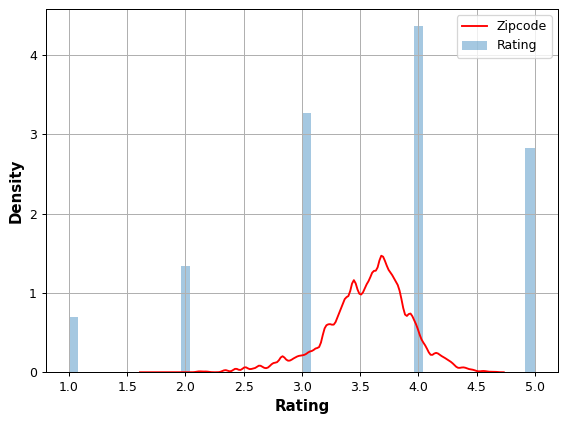

In [38]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=False, norm_hist=True)
ax = sns.kdeplot(X_train.Zipcode, color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating'])
plt.grid(True);

📊 **Phân tích phân phối của `Zipcode` đã mã hóa**  

✅ Phân phối của đặc trưng `Zipcode` sau khi mã hóa **tương đồng với phân phối thực tế của đánh giá**.  
Điều này cho thấy người xem phim có sự khác biệt rõ rệt về đánh giá **giữa các khu vực**.  

🔍 **Target encoding đã giúp nắm bắt thông tin hữu ích!**  

---

# 🎯 **Đến lượt bạn!**  

📌 [**Áp dụng target encoding**](https://www.kaggle.com/kernels/fork/14393917)  
trên tập dữ liệu *Ames* 🏡 và khám phá một cách **bất ngờ** mà target encoding có thể gây **overfitting**! 🚀  

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/feature-engineering/discussion) to chat with other learners.*